# 01 — Data Preparation (ADE Corpus V2, Classification)

**Goal.** Load the dataset, run quality checks, clean and de-duplicate text, guard against leakage, create stratified train and validation splits, and save standardized artifacts for all downstream notebooks.


In [1]:
from pathlib import Path
import os, sys, importlib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

CANDIDATES = [
    Path("/content/drive/MyDrive/masters_math/capestone/Final_project/Final_project"),
    Path("/content/drive/masters_math/capestone/Final_project/Final_project"),
]
PROJECT_ROOT = next((p for p in CANDIDATES if (p/"src"/"utilities.py").exists()), None)
assert PROJECT_ROOT, "Couldn't find src/utilities.py. Check Drive path."

SRC_DIR = PROJECT_ROOT / "src"
init_file = SRC_DIR / "__init__.py"
if not init_file.exists():
    init_file.write_text(
        "from .utilities import *\n"
        "from .plots import *\n"
        "from .hf_utils import *\n"
    )


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Environment and project paths

- Project root is auto-detected from Google Drive candidates and must contain `src/utilities.py`
- Key folders used in this notebook:
  - `artifacts/` for cleaned splits, class weights, and a split manifest
  - `plots/` for EDA overview images
- All paths are resolved relative to `PROJECT_ROOT`, which in this setup is:
  `/content/drive/.../Final_project/Final_project`


In [3]:
# imports from src
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))
importlib.invalidate_caches()
import src; importlib.reload(src)
from src import compute_class_weights

from src import (
    set_seed, ensure_dir, save_json, load_json,
    light_clean, norm_for_dedup, label_balance, choose_text_col,
    token_length_stats
)


In [4]:
# project dirs + seed
ARTIFACTS_DIR = ensure_dir(PROJECT_ROOT / "artifacts")
PLOTS_DIR     = ensure_dir(PROJECT_ROOT / "plots")
set_seed(42)

print("src loaded from:", src.__file__)
print("ARTIFACTS_DIR:", ARTIFACTS_DIR)
print("PLOTS_DIR:", PLOTS_DIR)

try:
    ARTI_DIR
except NameError:
    ARTI_DIR  = ensure_dir(PROJECT_ROOT / "artifacts")
    PLOTS_DIR = ensure_dir(PROJECT_ROOT / "plots")
ARTIFACTS_DIR = ARTI_DIR

src loaded from: /content/drive/MyDrive/masters_math/capestone/Final_project/Final_project/src/__init__.py
ARTIFACTS_DIR: /content/drive/MyDrive/masters_math/capestone/Final_project/Final_project/artifacts
PLOTS_DIR: /content/drive/MyDrive/masters_math/capestone/Final_project/Final_project/plots


# **Data Load**
## **ADE Corpus V2 (classification)**

## Data source and scope

- **Dataset:** ADE Corpus V2 (binary classification: adverse drug event vs not adverse drug event)
- **Ingestion:** Direct read from Hugging Face parquet endpoints
- **Task scope:** Single-sentence binary classification on cleaned text
- **Outputs:** Clean splits and metadata saved under `artifacts` and figures under `plots`


In [5]:
# source HuggingFace parquet endpoints
train_url = "https://huggingface.co/api/datasets/SetFit/ade_corpus_v2_classification/parquet/default/train/0000.parquet"
test_url  = "https://huggingface.co/api/datasets/SetFit/ade_corpus_v2_classification/parquet/default/test/0000.parquet"

train_full = pd.read_parquet(train_url)
test_df    = pd.read_parquet(test_url)

train_full.head(5)


,text,label,label_text
0,"On cessation of the injections, the retrocorne...",0,Not-Related
1,Median patient age was 52 years.,0,Not-Related
2,A whole brain irradiation was performed for 37...,0,Not-Related
3,Complex biochemical syndrome of hypocalcemia a...,0,Not-Related
4,The fastidious organism grew only on buffered ...,0,Not-Related


In [6]:
for df in (train_full, test_df):
    df["text"]  = df["text"].astype(str)
    df["label"] = df["label"].astype(int)
    assert set(df["label"].unique()).issubset({0, 1}), "labels must be 0/1"
    if "label_text" in df.columns:
        std_map = {"Not-Related": "Not ADE", "Related": "ADE"}
        df["label_text_std"] = df["label_text"].map(std_map)

label_map = {0: "Not ADE", 1: "ADE"}

if "label_text" in train_full.columns:
    print("\nLabel ... label_text consistency (train):")
    display(pd.crosstab(train_full["label"], train_full["label_text"]))

display(train_full.head(3))



Label ... label_text consistency (train):


label_text,Not-Related,Related
label,,
0,12492,0
1,0,5145


,text,label,label_text,label_text_std
0,"On cessation of the injections, the retrocorne...",0,Not-Related,Not ADE
1,Median patient age was 52 years.,0,Not-Related,Not ADE
2,A whole brain irradiation was performed for 37...,0,Not-Related,Not ADE


In [7]:
def _header(title):
    print(title)
    print("-" * len(title))

train_bal = label_balance(train_full)
test_bal  = label_balance(test_df)

print("ADE Corpus V2 — loaded\n")

# rows
_header("Rows")
print(f"train: {len(train_full):,}")
print(f"test : {len(test_df):,}")
print()

# balance
_header("Balance")
print("train")
print(f"  Not ADE : {train_bal['count_not_ade']:,}")
print(f"  ADE     : {train_bal['count_ade']:,}")
print(f"  ADE ratio: {train_bal['ade_ratio']:.3f}")
print("test")
print(f"  Not ADE : {test_bal['count_not_ade']:,}")
print(f"  ADE     : {test_bal['count_ade']:,}")
print(f"  ADE ratio: {test_bal['ade_ratio']:.3f}")
print()

# Label map
_header("Label Map")
for k in sorted(label_map):
    print(f"{k} → {label_map[k]}")

# label vs label_text consistency table (if present)
if "label_text" in train_full.columns:
    print()
    _header("Label ↔ label_text consistency (train)")
    ct = pd.crosstab(
        train_full["label"].map(label_map),
        train_full["label_text"]
    )
    display(ct)



ADE Corpus V2 — loaded

Rows
----
train: 17,637
test : 5,879

Balance
-------
train
  Not ADE : 12,492
  ADE     : 5,145
  ADE ratio: 0.292
test
  Not ADE : 4,203
  ADE     : 1,676
  ADE ratio: 0.285

Label Map
---------
0 → Not ADE
1 → ADE

Label ↔ label_text consistency (train)
--------------------------------------


label_text,Not-Related,Related
label,,
ADE,0,5145
Not ADE,12492,0


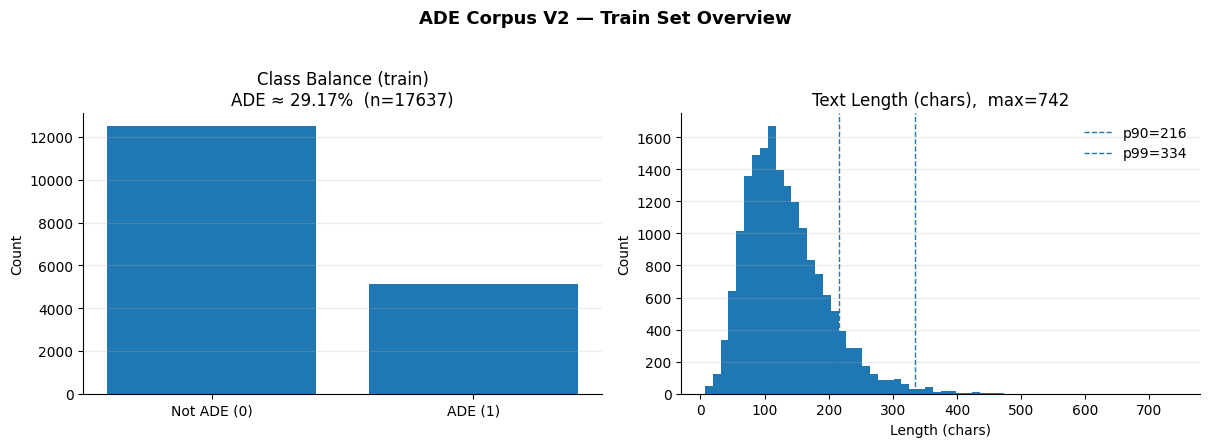

Saved:
 - /content/drive/MyDrive/masters_math/capestone/Final_project/Final_project/plots/eda_overview.png
 - /content/drive/MyDrive/masters_math/capestone/Final_project/Final_project/plots/eda_class_balance.png
 - /content/drive/MyDrive/masters_math/capestone/Final_project/Final_project/plots/eda_text_length_hist.png


In [8]:
# TRAIN only
train_counts = train_full["label"].value_counts().reindex([0, 1]).fillna(0).astype(int)
train_total  = int(train_counts.sum())
ade_pct      = float((train_counts.get(1, 0) / train_total) * 100.0) if train_total else 0.0
train_lens   = train_full["text"].astype(str).str.len()
p90 = int(train_lens.quantile(0.90)); p99 = int(train_lens.quantile(0.99)); mx = int(train_lens.max())

def prettify(ax):
    ax.grid(True, axis="y", alpha=0.25)
    for spine in ("top", "right"):
        ax.spines[spine].set_visible(False)

fig, axes = plt.subplots(1, 2, figsize=(12.2, 4.3))

# left class balance
axes[0].bar(["Not ADE (0)", "ADE (1)"], [train_counts.get(0, 0), train_counts.get(1, 0)])
axes[0].set_title(f"Class Balance (train)\nADE ≈ {ade_pct:.2f}%  (n={train_total})", fontsize=12)
axes[0].set_ylabel("Count")
prettify(axes[0])

# right text length histogram
axes[1].hist(train_lens, bins=60)
axes[1].axvline(p90, linestyle="--", linewidth=1, label=f"p90={p90}")
axes[1].axvline(p99, linestyle="--", linewidth=1, label=f"p99={p99}")
axes[1].set_title(f"Text Length (chars),  max={mx}", fontsize=12)
axes[1].set_xlabel("Length (chars)")
axes[1].set_ylabel("Count")
axes[1].legend(frameon=False)
prettify(axes[1])

fig.suptitle("ADE Corpus V2 — Train Set Overview", fontsize=13, fontweight="bold", y=1.03)
fig.tight_layout()

# save combined + individual
overview_path = PLOTS_DIR / "eda_overview.png"
fig.savefig(overview_path, dpi=150, bbox_inches="tight")

cb_path  = PLOTS_DIR / "eda_class_balance.png"
len_path = PLOTS_DIR / "eda_text_length_hist.png"

plt.figure(figsize=(4,3))
plt.bar(["Not ADE (0)", "ADE (1)"], [train_counts.get(0, 0), train_counts.get(1, 0)])
plt.tight_layout(); plt.savefig(cb_path, dpi=150); plt.close()

plt.figure(figsize=(5,3))
plt.hist(train_lens, bins=60); plt.axvline(p90, ls="--"); plt.axvline(p99, ls="--")
plt.tight_layout(); plt.savefig(len_path, dpi=150); plt.close()

plt.show()
print("Saved:")
print(" -", overview_path.resolve())
print(" -", cb_path.resolve())
print(" -", len_path.resolve())


- Not ADE is the majority; ADE is about 29 percent of the training set (n 17,637).
- The dataset is imbalanced, so accuracy alone can be misleading.
- Most texts are short, clustered around roughly 80 to 150 characters.
- About 90 percent of texts are under about 216 characters; 99 percent are under about 334.
- A small long tail reaches about 742 characters; a tokenizer max length near 256 covers most cases, and 320 to 384 covers nearly all.


# **Data Quality Diagnostics (dups, length stats, empty)**

In [9]:

assert {"text", "label"}.issubset(train_full.columns), "train_full missing text/label"
assert {"text", "label"}.issubset(test_df.columns),  "test_df missing text/label"
assert set(train_full["label"].unique()).issubset({0, 1}), "labels must be 0/1"
assert set(test_df["label"].unique()).issubset({0, 1}),    "labels must be 0/1"

def audit(df):
    s = df["text"].astype(str)
    lens = s.str.len()
    empty = s.str.strip().eq("").sum()
    return {
        "rows": len(df),
        "null_text": int(df["text"].isna().sum()),
        "empty_text": int(empty),
        "exact_dups_text": int(df.duplicated(subset=["text"]).sum()),
        "ade_pct": round((df["label"] == 1).mean(), 3),
        "p90_len": int(lens.quantile(0.90)),
        "p99_len": int(lens.quantile(0.99)),
        "max_len": int(lens.max()),
    }

raw_audit = pd.DataFrame({"train_raw": audit(train_full), "test_raw": audit(test_df)}).T
print("Raw audit:")
display(raw_audit)

# train/test overlapping exact text (pre-cleaning)
raw_overlap_exact = len(set(train_full["text"].astype(str)) & set(test_df["text"].astype(str)))
print(f"raw train ... test exact overlap (by text): {raw_overlap_exact}")



Raw audit:


,rows,null_text,empty_text,exact_dups_text,ade_pct,p90_len,p99_len,max_len
train_raw,17637.0,0.0,0.0,1718.0,0.292,216.0,334.0,742.0
test_raw,5879.0,0.0,0.0,253.0,0.285,211.0,314.0,573.0


raw train ... test exact overlap (by text): 649


In [10]:
# normalized overlap (lowercase, strip punctuation/extra spaces) — early leak check
train_norm = set(train_full["text"].astype(str).map(norm_for_dedup))
test_norm  = set(test_df["text"].astype(str).map(norm_for_dedup))
raw_overlap_norm = len(train_norm & test_norm)
print(f"raw train ... test normalized overlap: {raw_overlap_norm}")

def quick_audit(df, name="df"):
    txt = df["text"].astype(str)
    is_null   = df["text"].isna()
    is_empty  = txt.str.strip().eq("")
    dup_text  = df["text"].duplicated(keep="first")
    dup_rows  = df.duplicated(keep="first")

    label_num = pd.to_numeric(df["label"], errors="coerce")
    invalid_label = ~(label_num.isin([0, 1]))

    lengths = txt.str.len()

    print(f"\n=== {name} — RAW AUDIT (no cleaning) ===")
    print(f"rows: {len(df):,}")
    print(f"null text: {is_null.sum():,}")
    print(f"empty/whitespace text: {is_empty.sum():,}")
    print(f"duplicate texts: {dup_text.sum():,}")
    print(f"duplicate rows: {dup_rows.sum():,}")
    print(f"invalid labels (not 0/1 or NaN): {invalid_label.sum():,}")
    if len(lengths):
        p50 = int(lengths.quantile(0.50))
        p90 = int(lengths.quantile(0.90))
        print(f"text length (min/median/p90/max): {int(lengths.min())} / {p50} / {p90} / {int(lengths.max())}")

    if (is_null | is_empty).any():
        print("\nExamples of empty/null text rows:")
        display(df.loc[is_null | is_empty, ["text","label"]].head(5))

    if dup_text.any():
        print("\nTop duplicate texts (by frequency, head):")
        dup_counts = df["text"].value_counts()
        dup_counts = dup_counts[dup_counts > 1].head(10)
        display(dup_counts.to_frame("freq"))

quick_audit(train_full, "train")
quick_audit(test_df, "test")

raw train ... test normalized overlap: 649

=== train — RAW AUDIT (no cleaning) ===
rows: 17,637
null text: 0
empty/whitespace text: 0
duplicate texts: 1,718
duplicate rows: 1,718
invalid labels (not 0/1 or NaN): 0
text length (min/median/p90/max): 7 / 123 / 216 / 742

Top duplicate texts (by frequency, head):


,freq
text,
"CASE SUMMARY: A 65-year-old patient chronically treated with the selective serotonin reuptake inhibitor (SSRI) citalopram developed confusion, agitation, tachycardia, tremors, myoclonic jerks and unsteady gait, consistent with serotonin syndrome, following initiation of fentanyl, and all symptoms and signs resolved following discontinuation of fentanyl.",17
"A 27-year-old man who had a history of bronchial asthma, eosinophilic enteritis, and eosinophilic pneumonia presented with fever, skin eruptions, cervical lymphadenopathy, hepatosplenomegaly, atypical lymphocytosis, and eosinophilia two weeks after receiving trimethoprim (TMP)-sulfamethoxazole (SMX) treatment.",17
A case report.,16
"Three patients, in whom tumour overkill by cytotoxic treatment, including high dose methotrexate with folinic acid rescue, resulted in the 'phosphate shower syndrome' (hyper-uricaemia, hyperkalaemia and hyperphosphataemia with hypocalcaemia and tetany, with metabolic acidosis and acute renal impairment) are described.",15
"Rapamycin/sirolimus (SR), trade named Rapammune (Wyeth-Ayerst, Sydney, Australia), is a potent immunosuppressive drug associated with myelosuppression, hypertension, hyperlipidemia, and infection.",13
"A 14-year-old female developed systemic lupus erythematosus (SLE)-like symptoms, rash, fever, leukopenia and positive anti-nuclear antibody (ANA) two weeks after administration of carbamazepine (CBZ; Tegretol) used against benign Rolandic epilepsy.",12
"CONCLUSION: The new quinolone derivatives (levofloxacin, sparfloxacin, grepafloxacin, trovafloxacin, gatifloxacin and moxifloxacin), also called gyrase inhibitors, are known for their potential to cause central nervous system-related adverse effects, including headache, dizziness and insomnia.",12
"In case no. 2, the pathogenic mechanism seemed to be persistent light reaction preceded by systemic photoallergy, as he had taken mequitazine for 6 months, and there were strong positive photopatch test results with immediate erythema reaction, cross-reaction to promethazine, decreased MED to both UVA and UVB, and persistence of the photosensitivity over a 3-year follow-up period after discontinuation of the mequitazine.",11
"Two patients with ovarian cancer who had received multiple courses of cisplatin without complications experienced hypersensitivity reactions to cisplatin: one, involving intrahepatic artery infusion, manifested general erythema, dyspnea, and hypotension; the other, involving intravenous infusion, manifested abdominal pain, general erythema, and fever.",11



=== test — RAW AUDIT (no cleaning) ===
rows: 5,879
null text: 0
empty/whitespace text: 0
duplicate texts: 253
duplicate rows: 253
invalid labels (not 0/1 or NaN): 0
text length (min/median/p90/max): 8 / 121 / 211 / 573

Top duplicate texts (by frequency, head):


,freq
text,
"A 27-year-old man who had a history of bronchial asthma, eosinophilic enteritis, and eosinophilic pneumonia presented with fever, skin eruptions, cervical lymphadenopathy, hepatosplenomegaly, atypical lymphocytosis, and eosinophilia two weeks after receiving trimethoprim (TMP)-sulfamethoxazole (SMX) treatment.",7
"CONCLUSION: The new quinolone derivatives (levofloxacin, sparfloxacin, grepafloxacin, trovafloxacin, gatifloxacin and moxifloxacin), also called gyrase inhibitors, are known for their potential to cause central nervous system-related adverse effects, including headache, dizziness and insomnia.",6
A case report.,5
Two patients treated with 5-fluorouracil (5-FU) for disseminated adenocarcinoma of the colon developed cerebellar dysfunction typical of 5-FU neurotoxicity.,5
We report a patient with pulmonary adenocarcinoma complicated by the syndrome of inappropriate secretion of antidiuretic hormone (SIADH) following systemic chemotherapy with cisplatin (CDDP) and vindesine (VDS).,5
"When SASP was changed to 5-aminosalicylic acid (5-ASA), his skin eruptions were resolved, however, he developed weakness and atrophy in his right arm as well as progressive worsening of the dysesthesia in his legs and gait disturbance.",4
"The current report describes a man who was prescribed zonisamide for epilepsy and subsequently developed widespread skin rash, acute kidney injury, high-grade fever, eosinophilia, liver dysfunction, lymphadenopathy and an increase in antihuman herpesvirus-6 immunoglobulin G titer.",4
OBJECTIVE: To report 2 cases of serotonin syndrome with serious extrapyramidal movement disorders occurring when metoclopramide was coadministered with sertraline or venlafaxine.,4
"CONCLUSIONS: Topiramate may be associated with ciliochoroidal effusion with forward displacement of the lens-iris diaphragm and anterior chamber shallowing, resulting in acute myopia and angle-closure glaucoma.",4


# **Data Cleaning**

### **Clean, de-duplicate, guard against leakage, stratified split, save artifacts**

### steps applied

- Dropped rows with empty or whitespace-only text
- Built two standardized text fields:
  - `text_clean`: light whitespace and spacing normalization
  - `text_norm`: lowercased, punctuation-stripped normalization for de-duplication and leakage checks
- Removed exact duplicates within each split by `text_clean`
- Resolved conflicting labels in training examples by keeping the majority label per normalized text
- Leakage guard:
  - Removed any training rows whose normalized text appears in the test set


In [11]:
def drop_empty(df: pd.DataFrame) -> pd.DataFrame:
    m = df["text"].astype(str).str.strip().str.len() > 0
    return df.loc[m].reset_index(drop=True)

# basic cleaning & text variants
train_full = drop_empty(train_full)
test_df    = drop_empty(test_df)

for df in (train_full, test_df):
    df["text_clean"] = df["text"].apply(light_clean)
    df["text_norm"]  = df["text_clean"].apply(norm_for_dedup)
    df["label"]      = df["label"].astype(int)

# remove exact duplicates within each split (by text_clean) — report counts
dup_train = int(train_full.duplicated(subset=["text_clean"]).sum())
dup_test  = int(test_df.duplicated(subset=["text_clean"]).sum())
train_full = train_full.drop_duplicates(subset=["text_clean"]).reset_index(drop=True)
test_df    = test_df.drop_duplicates(subset=["text_clean"]).reset_index(drop=True)

# resolve conflicting labels inside train (keep majority label per normalized text)
conf = train_full.groupby("text_norm")["label"].nunique()
if (conf > 1).any():
    g = (
        train_full.groupby(["text_norm","label"]).size()
        .reset_index(name="cnt")
        .sort_values(["text_norm","cnt"], ascending=[True, False])
        .drop_duplicates(subset=["text_norm"])
    )
    keep = set(zip(g["text_norm"], g["label"]))
    train_full = train_full[
        train_full.apply(lambda r: (r["text_norm"], r["label"]) in keep, axis=1)
    ].reset_index(drop=True)

# leakage guard: drop train rows whose normalized text appears in test (report rows removed)
pre_n = len(train_full)
overlap_norm = set(train_full["text_norm"]) & set(test_df["text_norm"])
if overlap_norm:
    train_full = train_full[~train_full["text_norm"].isin(overlap_norm)].reset_index(drop=True)
leak_dropped = pre_n - len(train_full)

# stratified split (train/val)
from sklearn.model_selection import train_test_split
SEED = 42
train_df, val_df = train_test_split(
    train_full, test_size=0.10, stratify=train_full["label"], random_state=SEED
)
train_df = train_df.reset_index(drop=True)
val_df   = val_df.reset_index(drop=True)
test_df  = test_df.reset_index(drop=True)

# stable ids
train_df["uid"] = [f"tr_{i}" for i in range(len(train_df))]
val_df["uid"]   = [f"va_{i}" for i in range(len(val_df))]
test_df["uid"]  = [f"te_{i}" for i in range(len(test_df))]

# class weights (train only) via src
cw = compute_class_weights(train_df["label"])         # numpy array [w0, w1]
class_weights = {0: float(cw[0]), 1: float(cw[1])}

# save artifacts
ensure_dir(ARTIFACTS_DIR)
train_path = ARTIFACTS_DIR / "train_clean.csv"
val_path   = ARTIFACTS_DIR / "val_clean.csv"
test_path  = ARTIFACTS_DIR / "test_clean.csv"
cw_path    = ARTIFACTS_DIR / "class_weights.json"


train_df.to_csv(train_path, index=False)
val_df.to_csv(val_path, index=False)
test_df.to_csv(test_path, index=False)
save_json(class_weights, cw_path)

# single manifest (join key = uid)
man_rows = []
for split_name, df_ in (("train", train_df), ("val", val_df), ("test", test_df)):
    tmp = df_[["uid", "text_clean", "label"]].copy()
    tmp.rename(columns={"text_clean": "text"}, inplace=True)
    tmp["split"] = split_name
    man_rows.append(tmp)
manifest = pd.concat(man_rows, ignore_index=True)
manifest_path = ARTI_DIR / "split_manifest.csv"
manifest.to_csv(manifest_path, index=False)

### Train, validation, test split — confirmation

- The split is stratified with a fixed seed (42).
- The test set is kept as provided after cleaning and de-duplication.
- Counts: train 13,743; validation 1,527; test 5,626. ADE share is about 19 percent in train and validation, about 25 percent in test.


In [12]:
# check of cleaning
def assert_no_dups_overlap(train_df, val_df, test_df, text_col="text_clean", norm_col="text_norm"):
    """Fail-fast if there are duplicates within splits or overlaps across splits."""
    def _zero(msg, v):
        if v != 0:
            raise AssertionError(f"{msg}: expected 0, got {v}")

    # within split dupes
    _zero("dupes in train", train_df.duplicated([text_col]).sum())
    _zero("dupes in val",   val_df.duplicated([text_col]).sum())
    _zero("dupes in test",  test_df.duplicated([text_col]).sum())

    # cross split overlaps on normalized text (guard against leakage)
    def _ol(a, b, col):
        return len(set(a[col]) & set(b[col]))

    if norm_col in train_df.columns and norm_col in val_df.columns and norm_col in test_df.columns:
        _zero("train…val normalized overlap",  _ol(train_df, val_df, norm_col))
        _zero("train…test normalized overlap", _ol(train_df, test_df, norm_col))
        _zero("val…test normalized overlap",   _ol(val_df,  test_df, norm_col))
    else:
        _zero("train…val raw overlap",  _ol(train_df, val_df, text_col))
        _zero("train…test raw overlap", _ol(train_df, test_df, text_col))
        _zero("val…test raw overlap",   _ol(val_df,  test_df, text_col))

# run checks
assert_no_dups_overlap(train_df, val_df, test_df, text_col="text_clean", norm_col="text_norm")

print("Cleaning & Leakage Guard:")
print(f" - Dropped empties, de-duped by text_clean (train={dup_train}, test={dup_test})")
print(f" - Removed train...test overlaps by text_norm: {leak_dropped}")
print(f" - Stratified split - train={len(train_df)}, val={len(val_df)}, test={len(test_df)}")
print(f" - Class weights - {class_weights}")
print(f" - Manifest -> {manifest_path}")


Cleaning & Leakage Guard:
 - Dropped empties, de-duped by text_clean (train=1718, test=253)
 - Removed train...test overlaps by text_norm: 649
 - Stratified split - train=13743, val=1527, test=5626
 - Class weights - {0: 0.3719711853307138, 1: 1.628028814669286}
 - Manifest -> /content/drive/MyDrive/masters_math/capestone/Final_project/Final_project/artifacts/split_manifest.csv


,Not ADE,ADE,rows
split,,,
Train,11187,2556,13743
Val,1243,284,1527
Test,4195,1431,5626


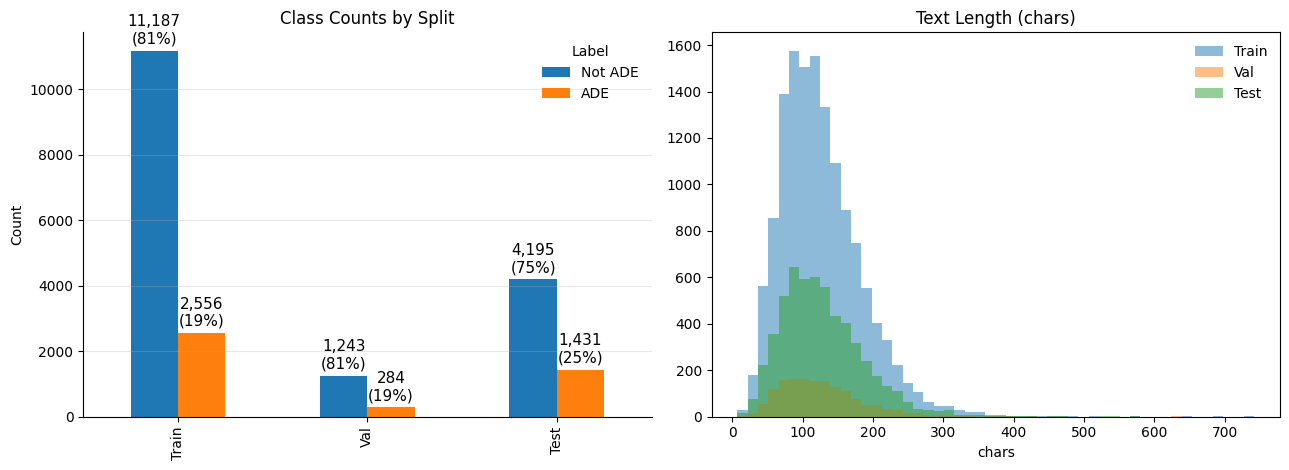

(class balance + length) saved to: /content/drive/MyDrive/masters_math/capestone/Final_project/Final_project/plots


In [17]:
TEXT_COL = "text_clean" if "text_clean" in train_df.columns else "text"
splits = [("Train", train_df), ("Val", val_df), ("Test", test_df)]

# small counts table
counts = pd.DataFrame([
    {"split": name,
     "Not ADE": int((df["label"] == 0).sum()),
     "ADE":     int((df["label"] == 1).sum()),
     "rows":    len(df)}
    for name, df in splits
]).set_index("split")
display(counts)

#  plots
fig, axes = plt.subplots(1, 2, figsize=(13, 4.8))

# class balance bars
ax0 = axes[0]
counts[["Not ADE", "ADE"]].plot(kind="bar", ax=ax0)

ax0.set_title("Class Counts by Split")
ax0.set_xlabel("")
ax0.set_ylabel("Count")
ax0.grid(axis="y", alpha=0.3)
ax0.legend(title="Label", frameon=False)

# de-spine
for side in ("top", "right"):
    ax0.spines[side].set_visible(False)

# annotate bars with count and % of split
for container, col in zip(ax0.containers, ["Not ADE", "ADE"]):
    for rect, split_name in zip(container, counts.index):
        count = int(rect.get_height())
        total = int(counts.loc[split_name, "rows"])
        pct = (count / total) if total else 0
        ax0.annotate(f"{count:,}\n({pct:.0%})",
                     xy=(rect.get_x() + rect.get_width()/2, rect.get_height()),
                     xytext=(0, 3), textcoords="offset points",
                     ha="center", va="bottom", fontsize=11)

# text length histograms (shared bins)
all_lens = pd.concat([df[TEXT_COL].str.len() for _, df in splits])
bins = np.histogram_bin_edges(all_lens, bins=50)
for name, df in splits:
    axes[1].hist(df[TEXT_COL].str.len(), bins=bins, alpha=0.5, label=name)
axes[1].set_title("Text Length (chars)")
axes[1].set_xlabel("chars")
axes[1].legend(frameon=False)

plt.tight_layout()
plt.savefig(PLOTS_DIR / "row_counts_lengths_by_split.png", dpi=200)
plt.show()

print("(class balance + length) saved to:", PLOTS_DIR)



- Splits remain stratified and imbalanced: train and validation have about 19 percent ADE; test has about 25 percent ADE.
- Row counts are about 13,743 for train, 1,527 for validation, and 5,626 for test.
- Length distributions overlap closely across splits, which suggests no major distribution shift.
- Most examples in all splits are under about 250 to 300 characters.
- One tokenizer max length can be used across splits without introducing split-specific artifacts.


In [14]:
def quick_audit(df):
    txt = df[TEXT_COL].astype(str)
    is_null  = df[TEXT_COL].isna()
    is_empty = txt.str.strip().eq("")
    dup_text = df[TEXT_COL].duplicated(keep="first")
    dup_rows = df.duplicated(keep="first")
    lengths  = txt.str.len()
    return {
        "rows": len(df),
        "null_text": int(is_null.sum()),
        "empty_text": int(is_empty.sum()),
        "dup_text": int(dup_text.sum()),
        "dup_rows": int(dup_rows.sum()),
        "p50_len": int(lengths.quantile(0.50)) if len(lengths) else 0,
        "p90_len": int(lengths.quantile(0.90)) if len(lengths) else 0,
        "max_len": int(lengths.max()) if len(lengths) else 0,
        "ade_pct": float((df["label"] == 1).mean()),
    }

qa = pd.DataFrame({
    "train_clean": quick_audit(train_df),
    "val_clean":   quick_audit(val_df),
    "test_clean":  quick_audit(test_df),
}).T
display(qa)

# explicit post-split overlap counts (normalized)
tv_ol = len(set(train_df["text_norm"]) & set(val_df["text_norm"]))
tt_ol = len(set(train_df["text_norm"]) & set(test_df["text_norm"]))
vt_ol = len(set(val_df["text_norm"])   & set(test_df["text_norm"]))
print(f"post-split normalized overlaps — train…val={tv_ol}, train…test={tt_ol}, val…test={vt_ol}")

,rows,null_text,empty_text,dup_text,dup_rows,p50_len,p90_len,max_len,ade_pct
train_clean,13743.0,0.0,0.0,0.0,0.0,116.0,201.0,742.0,0.185986
val_clean,1527.0,0.0,0.0,0.0,0.0,117.0,204.0,637.0,0.185986
test_clean,5626.0,0.0,0.0,0.0,0.0,119.0,204.0,573.0,0.254355


post-split normalized overlaps — train…val=0, train…test=0, val…test=0
